In [90]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torchmetrics


In [91]:
torch.manual_seed(42)

# Dataset

In [3]:
progeria = pd.read_csv(r"230705_progeria_c2/IdentifyPrimaryObjects.csv")
normal = pd.read_csv(r"230705_normal_c2/IdentifyPrimaryObjects.csv")
cols_to_drop = ["ImageNumber", "ObjectNumber", "Number_Object_Number"]
size_based = ["AreaShape_Area","AreaShape_Perimeter", "AreaShape_BoundingBoxArea", "AreaShape_BoundingBoxMaximum_X", "AreaShape_BoundingBoxMaximum_Y", "AreaShape_BoundingBoxMinimum_X", "AreaShape_BoundingBoxMinimum_Y", "AreaShape_ConvexArea", "AreaShape_EquivalentDiameter", "AreaShape_MajorAxisLength", "AreaShape_MinorAxisLength", "AreaShape_MaxFeretDiameter", "AreaShape_MinFeretDiameter", "AreaShape_MaximumRadius", "AreaShape_MeanRadius", "AreaShape_MedianRadius"]
posn_based = ["AreaShape_Center_X", "AreaShape_Center_Y", "Location_Center_X", "Location_Center_Z"]
					
progeria_features = progeria.drop(columns=cols_to_drop + size_based + posn_based)
progeria_features = progeria_features.assign(label=1) 
normal_features = normal.drop(columns=cols_to_drop + size_based + posn_based)
normal_features = normal_features.assign(label=0) 
full_data = pd.concat([progeria_features, normal_features],axis=0)
full_data = full_data.replace([np.inf, -np.inf], np.nan)
full_data = full_data.dropna()
n_cells, n_feats = np.shape(full_data)

In [4]:
class CellFeaturesDataset(Dataset):
    def __init__(self, fulldata, transform=None, target_transform=None):
        self.labels = fulldata.loc[:,'label'].values
        self.data = fulldata.loc[:,~fulldata.columns.isin(['label'])].values
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        item = self.data[idx,:]
        label = self.labels[idx]
        if self.transform:
            item = self.transform(item)
        if self.target_transform:
            label = self.target_transform(label)
        return item.float(), label.float()

## Transform data - scale and convert to tensor

In [5]:
def tensor_and_scale (x):
    m = x.mean(0)
    s = x.std(0)
    x -= m
    x /= s
    # torch.allclose(x, torch.from_numpy(arr_norm))
    return torch.as_tensor(x)

t = tensor_and_scale

In [6]:
cell_dataset = CellFeaturesDataset(full_data, transform=t, target_transform=torch.as_tensor)

## Train-test split, create dataloaders

In [7]:
from sklearn.model_selection import train_test_split

train_cells, test_cells = train_test_split(cell_dataset, stratify=cell_dataset.labels, test_size=0.35, random_state=42)

In [8]:
from collections import Counter

normal_wt = Counter([x[1].item() for x in train_cells])[0.0]/len(train_cells)
progeria_wt = 1 - normal_wt

In [9]:
batch_size = 32

#sampler = torchsample.StratifiedSampler(class_vector=cell_dataset.labels, batch_size=batch_size)
#test_cells, train_cells = torch.utils.data.random_split(cell_dataset, [.3, .7])
train_dataloader = DataLoader(train_cells, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_cells, batch_size=batch_size, shuffle=True)

# ANN

In [10]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        # self.flatten = nn.Flatten()
        mid = (n_inputs+n_outputs)//2
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features=n_inputs, out_features=mid),
            nn.ReLU(),
            nn.Linear(in_features=mid, out_features=mid),
            nn.ReLU(),
            nn.Linear(in_features=mid, out_features=n_outputs),
        )
        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform(m.weight)
                m.bias.data.fill_(0.01)

        self.linear_relu_stack.apply(init_weights)

    def forward(self, x):
        # do stuff here
        logits = self.linear_relu_stack(x)
        prediction = torch.sigmoid(logits)
        return prediction

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [11]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    model.float()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y.long())
        optimizer.zero_grad()
        # Backpropagation
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        loss, current = loss.item(), (batch + 1) * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss

In [22]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    model.float()
    test_loss, correct, bal_acc = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            # X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)
            print(predicted)
            print(y)
            test_loss += loss_fn(outputs, y.long()).item()
            correct += (predicted == y).sum()
            bal_acc += torchmetrics.functional.classification.accuracy(predicted, y.long(), task='multiclass', num_classes=2, average='macro') 
    test_loss /= num_batches
    bal_acc /= num_batches
    correct = correct/size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg. balanced accuracy: {(bal_acc):>0.1f}, Avg loss: {test_loss:>8f} \n")
    return 100*correct, bal_acc, test_loss

## Run

In [23]:
learning_rate = 1e-3
epochs = 75
loss_fn = nn.NLLLoss(weight=torch.as_tensor([1/normal_wt, 1/progeria_wt]))
# reg_fn = nn.L1Loss()
model = NeuralNetwork(n_feats-1, 2)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

losses = []
accs = []
bal_accs = []
test_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    l = train(train_dataloader, model, loss_fn, optimizer)
    a, b_a, t_l = test(test_dataloader, model, loss_fn)
    losses.append(l)
    accs.append(a)
    bal_accs.append(b_a)
    test_losses.append(t_l)
print("Done!")

/var/folders/9v/k071n2b94dg01zdj54ydkdsw0000gn/T/ipykernel_12154/3268443563.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


Epoch 1
-------------------------------
loss: -0.304234  [   32/ 1457]
loss: -0.338994  [   64/ 1457]
loss: -0.309761  [   96/ 1457]
loss: -0.335650  [  128/ 1457]
loss: -0.298062  [  160/ 1457]
loss: -0.324092  [  192/ 1457]
loss: -0.307351  [  224/ 1457]
loss: -0.310576  [  256/ 1457]
loss: -0.316524  [  288/ 1457]
loss: -0.311230  [  320/ 1457]
loss: -0.320463  [  352/ 1457]
loss: -0.297483  [  384/ 1457]
loss: -0.318540  [  416/ 1457]
loss: -0.325951  [  448/ 1457]
loss: -0.327423  [  480/ 1457]
loss: -0.332025  [  512/ 1457]
loss: -0.304749  [  544/ 1457]
loss: -0.318769  [  576/ 1457]
loss: -0.312622  [  608/ 1457]
loss: -0.305387  [  640/ 1457]
loss: -0.341715  [  672/ 1457]
loss: -0.332264  [  704/ 1457]
loss: -0.338261  [  736/ 1457]
loss: -0.321737  [  768/ 1457]
loss: -0.319173  [  800/ 1457]
loss: -0.329654  [  832/ 1457]
loss: -0.330913  [  864/ 1457]
loss: -0.333420  [  896/ 1457]
loss: -0.350677  [  928/ 1457]
loss: -0.340504  [  960/ 1457]
loss: -0.319488  [  992/ 1457]

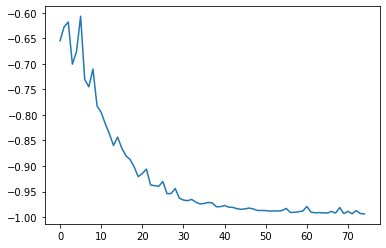

In [17]:
plt.plot(losses)

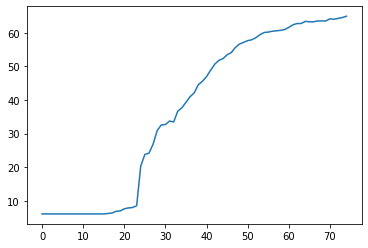

In [18]:
plt.plot(accs)

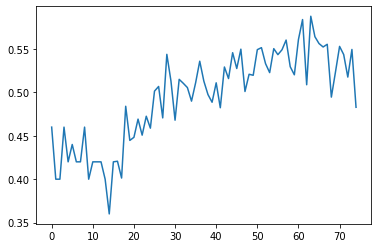

In [19]:
plt.plot(bal_accs)

# Logistic regression

In [28]:
class LogisticRegression(torch.nn.Module):    
    # build the constructor
    def __init__(self, n_inputs, n_outputs):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(n_inputs, n_outputs)
        torch.nn.init.uniform_(self.linear.weight, -0.01, 0.01) 
        torch.nn.init.zeros_(self.linear.bias)
    # make predictions
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

In [50]:
def train (dataloader, model, loss_fn, optimizer, use_closure = False):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        #print(X)
        outputs = model(X)
        loss = loss_fn(outputs, y.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if use_closure:
            def closure():
                optimizer.zero_grad()
                output = model(X)
                loss = loss_fn(output, y.long())
                loss.backward()
                return loss
            optimizer.step(closure)
        current = (batch + 1) * len(X)
        print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")
    print(loss.item())
    return loss.item()

In [57]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct, bal_acc = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)
            print(predicted)
            print(y)
            test_loss += loss_fn(outputs, y.long()).item()
            correct += (predicted == y).sum()
            bal_acc += torchmetrics.functional.classification.accuracy(predicted, y.long(), task='multiclass', num_classes=2, average='macro') 
    accuracy = 100 * (correct) / len(dataloader.dataset)
    test_loss /= num_batches
    bal_acc /= num_batches
    print(f"Test Error: \n Accuracy: {(accuracy):>0.1f}%, Avg. balanced accuracy: {(bal_acc):>0.1f}, Avg loss: {test_loss:>8f} \n")
    return accuracy, bal_acc, test_loss

## Run

In [86]:
log_regr = LogisticRegression(n_feats-1, 2)
# could use BCEWithLogitsLoss and pos_weight
loss_fn = torch.nn.NLLLoss(weight=torch.as_tensor([1/normal_wt, 1/progeria_wt]))
learning_rate = 1e-4
optimizer = torch.optim.SGD(log_regr.parameters(), lr=learning_rate)
opt2 = torch.optim.Adam(log_regr.parameters(), lr=learning_rate)
epochs = 100

losses = []
accs = []
bal_accs = []
test_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    l_t = train(train_dataloader, log_regr, loss_fn, optimizer)
    a_t, b_a, tl_t = test(test_dataloader, log_regr, loss_fn)
    losses.append(l_t)
    accs.append(a_t)
    bal_accs.append(b_a)
    test_losses.append(tl_t)
print("Done!")

Epoch 1
-------------------------------
loss: -0.501980  [   32/ 1457]
loss: -0.494421  [   64/ 1457]
loss: -0.495957  [   96/ 1457]
loss: -0.501663  [  128/ 1457]
loss: -0.491386  [  160/ 1457]
loss: -0.497171  [  192/ 1457]
loss: -0.500325  [  224/ 1457]
loss: -0.497335  [  256/ 1457]
loss: -0.499942  [  288/ 1457]
loss: -0.501559  [  320/ 1457]
loss: -0.497325  [  352/ 1457]
loss: -0.499610  [  384/ 1457]
loss: -0.497521  [  416/ 1457]
loss: -0.503107  [  448/ 1457]
loss: -0.497038  [  480/ 1457]
loss: -0.500678  [  512/ 1457]
loss: -0.502136  [  544/ 1457]
loss: -0.502808  [  576/ 1457]
loss: -0.503699  [  608/ 1457]
loss: -0.492535  [  640/ 1457]
loss: -0.498699  [  672/ 1457]
loss: -0.499480  [  704/ 1457]
loss: -0.502983  [  736/ 1457]
loss: -0.504361  [  768/ 1457]
loss: -0.504806  [  800/ 1457]
loss: -0.499294  [  832/ 1457]
loss: -0.502916  [  864/ 1457]
loss: -0.504294  [  896/ 1457]
loss: -0.505902  [  928/ 1457]
loss: -0.499588  [  960/ 1457]
loss: -0.498973  [  992/ 1457]

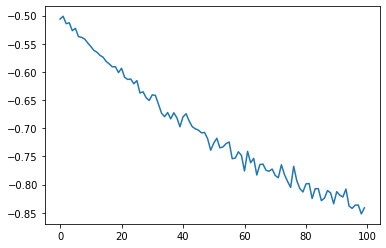

In [87]:
plt.plot(losses)

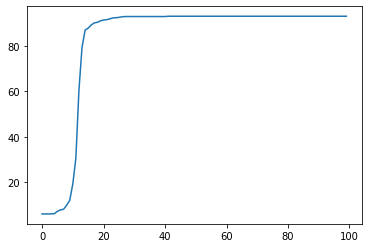

In [88]:
plt.plot(accs)

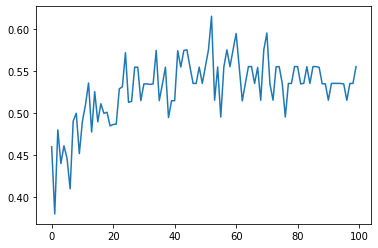

In [89]:
plt.plot(bal_accs)